In [54]:
%load_ext autoreload
%autoreload 2

## Named-entity recognition with a non-English dataset
This code generates the results and visuals from the presentation included in the repository.  However, due to privacy issues, I wasn't able to include the datasets.  The pickle files were just lists of different entity types in Chinese, so you should be able to plug and play a lot of this.

In [55]:
import pandas as pd
import numpy as np
from copy import deepcopy
from glob import glob
import json
import time
import numpy as np
import re
from spacy.matcher import Matcher, PhraseMatcher
from spacy.tokens import Span, Doc
from spacy.lang.zh import Chinese
from spacy.util import compounding, minibatch, random
from spacy import displacy

In [1]:
# import some utilities
from utils import *

In [58]:
# setting a custom entity extension to store information from patterns
Doc.set_extension('entities', default=[], force=True)
# establish pipe
nlp = Chinese()

In [59]:
# entity types (in order of preference)
# overlapping entity of index 0 and index 1, entity of index 0 chosen
ENTITY_TYPES = ['agencies', 'locations', 'products']

In [60]:
# sample inventory data
inventories = []
for e in ENTITY_TYPES:
    inventory = pd.read_pickle('./data/%s.pkl' % e)    
    print(e, inventory.shape)
    inventories.append(inventory)

agencies (5961,)
locations (396,)
products (46346,)


In [61]:
# spacy parse entities
parsed_ents = []
for i in inventories:
    parsed_ents.append(parse_text(i, nlp))

In [62]:
# Test for matcher
# Ensure that the type hierarchy is being properly implemented
matcher = PhraseMatcher(nlp.vocab)
for i, c in enumerate(ENTITY_TYPES):
    matcher.add(c, add_entity, *parsed_ents[i])
# combined each type needs actually a type instance that contains another type instance
# going to generate this
seed_idx = 3
agency_location = parsed_ents[0][seed_idx].text + parsed_ents[1][seed_idx].text
matcher.add('agencies', add_entity, nlp.make_doc(agency_location))
location_product = parsed_ents[1][seed_idx].text + parsed_ents[2][seed_idx].text
matcher.add('locations', add_entity, nlp.make_doc(location_product))
agency_product = parsed_ents[0][seed_idx].text + parsed_ents[2][seed_idx].text
matcher.add('agencies', add_entity, nlp.make_doc(agency_product))

In [63]:
# test add_entity
# need to create instance of isolated each type and combined each type
doc = ''
for i in range(len(parsed_ents)):
    doc+=parsed_ents[i][5].text + ' '
for x in [agency_location, location_product, agency_product]:
    doc+=x
parsed_d = nlp.make_doc(doc)
print(matcher(parsed_d))
[(x[1], x[0].start, x[0].end, 
  #translate(parsed_d[x[0].start:x[0].end].text)) for x in parsed_d._.entities]
  parsed_d[x[0].start:x[0].end].text) for x in parsed_d._.entities]

[(2833597281053035892, 0, 3), (13063876858105367867, 3, 4), (7206340754463407063, 4, 5), (2833597281053035892, 5, 8), (2833597281053035892, 5, 10), (13063876858105367867, 8, 10), (13063876858105367867, 10, 12), (13063876858105367867, 10, 13), (7206340754463407063, 12, 13), (2833597281053035892, 13, 16), (2833597281053035892, 13, 17), (7206340754463407063, 16, 17)]


[('agencies', 0, 3, '万荣县食药局'),
 ('locations', 3, 4, '上海'),
 ('products', 4, 5, '韭菜'),
 ('agencies', 5, 10, '万山区工商行政管理局三沙市'),
 ('locations', 10, 13, '三沙市小麦粉'),
 ('agencies', 13, 17, '万山区工商行政管理局小麦粉')]

In [ ]:
# intialize model
nlp = Chinese()
# initialize the matcher with model vocab
matcher = PhraseMatcher(nlp.vocab)
# add entity inventory as Doc objects from model
or i, c in enumerate(ENTITY_TYPES):
    matcher.add(c, add_entity, *parsed_ents[i])

In [64]:
# reinitialize matcher and add all parsed entities
matcher = PhraseMatcher(nlp.vocab)
for i, c in enumerate(ENTITY_TYPES):
    matcher.add(c, add_entity, *parsed_ents[i])

In [65]:
# read full dataset
all_cases = pd.read_pickle('./data/case_text.pkl')
parsed_cases = [nlp.make_doc(text) for text in all_cases['body']]

In [66]:
# run matcher on dataset, create annotated text
parsed_w_annotation = [fc for fc in matcher.pipe(parsed_cases)]

In [67]:
# make an inventory of the seen entities
# necessary for splitting train/test entities
# this is best designed as a matrix: documents x entities
all_entities = pd.concat(inventories).tolist()
doc_ent_mat = np.zeros(shape=(len(parsed_w_annotation), len(all_entities)))

In [68]:
for i, x in enumerate(parsed_w_annotation):
    seen_ents = set()
    for e in x._.entities:
        e_text = e[0].text
        if e_text not in seen_ents:
            type_idx = ENTITY_TYPES.index(e[1])
            try:
                e_idx = all_entities.index(e_text)
            except ValueError:
                # issue sometimes with matcher handling spaces
                e_idx = all_entities.index(re.sub(' ', '', e_text))
            doc_ent_mat[i, e_idx] = 1
            seen_ents.add(e_text)

In [69]:
def format_data(annotated_text, exclude=[]):
    # utility for formatting data for model
    # exclude: list of entities to exclude
    training = []
    for t in annotated_text:
        entities = []
        for p in t._.entities:
            if p[0].text not in exclude:
                entities.append((p[0].start_char, p[0].end_char, p[1]))
        training.append((t.text, {'entities':entities}))
    return(training)

In [70]:
# split by year
year_split = 2017
# indexes of cases for test
year_test_idxs = all_cases['year']>=year_split
# get entities that only exist post 2017
pre_ents_idxs = doc_ent_mat[~year_test_idxs].sum(axis=0)>0
post_ents_idxs = doc_ent_mat[year_test_idxs].sum(axis=0)>0
# only want those where post-pre = 1
year_ents_idxs = np.argwhere((post_ents_idxs.astype(int)-pre_ents_idxs.astype(int))==1).flatten()
year_ents = [all_entities[x] for x in year_ents_idxs]
# get train/test docs
year_train = [parsed_w_annotation[i] for i, x in enumerate(year_test_idxs) if not x]
year_test = [parsed_w_annotation[i] for i, x in enumerate(year_test_idxs) if x]
year_train_f = format_data(year_train)
year_test_f = format_data(year_test)
# baseline: test docs without entities from post 2017
year_baseline = format_data(year_test, exclude=year_ents)

In [182]:
# exclude random % entities of each type
test_pct = 0.3
offset = 0
exclude_ents = []
count_found_ents = 0
for i in range(len(inventories)):
    found_ents_idxs = doc_ent_mat[:, offset:offset+len(inventories[i])].sum(axis=0)>0
    found_ents = np.array(parsed_ents[i])[found_ents_idxs]
    sample_ents = np.random.choice(found_ents,
                                   size=round(len(found_ents)*test_pct), 
                                   replace=False)
    exclude_ents += [x.text for x in sample_ents]
    offset += len(inventories[i])
    count_found_ents += len(found_ents)

In [184]:
# random exclude, still do train/test split
test_idxs = np.random.random(size=len(parsed_w_annotation))<test_pct
exclude_train = [parsed_w_annotation[i] for i, x in enumerate(test_idxs) if not x]
exclude_test = [parsed_w_annotation[i] for i, x in enumerate(test_idxs) if x]
print(len(exclude_train), len(exclude_test), len(parsed_w_annotation))
exclude_train_f = format_data(exclude_train, exclude=exclude_ents)
exclude_test_f = format_data(exclude_test)
# baseline: test docs without excluded entities
exclude_baseline = format_data(exclude_test, exclude=exclude_ents)
# might want to run this multiple times?

14914 6309 21223


In [20]:
# save down, memory is sometimes an issue
import pickle
pickle.dump(exclude_train_f, open('data/exclude_train_f.pkl', 'wb'))
pickle.dump(exclude_test_f, open('data/exclude_test_f.pkl', 'wb'))
pickle.dump(exclude_baseline, open('data/exclude_baseline.pkl', 'wb'))

pickle.dump(year_train_f, open('data/year_train_f.pkl', 'wb'))
pickle.dump(year_test_f, open('data/year_test_f.pkl', 'wb'))
pickle.dump(year_baseline, open('data/year_baseline.pkl', 'wb'))

## Kill kernel here, if concerned about memory issues

In [3]:
import spacy
import pandas as pd
from spacy.matcher import Matcher, PhraseMatcher
from spacy.tokens import Span, Doc
from spacy.lang.zh import Chinese
from spacy.util import compounding, minibatch, random
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from spacy.gold import GoldParse
from spacy.scorer import Scorer
import numpy as np
import pickle
import sys
sys.path.append('src')
from utils import *
# establish pipe
nlp = Chinese()
ENTITY_TYPES = ['agencies', 'locations', 'products']

In [3]:
# load data for particular version
model_v = 'year'
train_data = pickle.load(open('data/{}_train_f.pkl'.format(model_v), 'rb'))
test_data = pickle.load(open('data/{}_test_f.pkl'.format(model_v), 'rb'))
baseline_data = pickle.load(open('data/{}_baseline.pkl'.format(model_v), 'rb'))

In [31]:
full_model = train_model(train_data, 'data/{}_model'.format(model_v), 
                         categories, epoch=15, nlp_model=None)

Losses {'ner': 150678.866278929}
Saving model
Losses {'ner': 71037.57341729387}
Saving model
Losses {'ner': 53585.542202386874}
Saving model
Losses {'ner': 44793.094466935225}
Saving model
Losses {'ner': 39181.79150611553}
Saving model
Losses {'ner': 36695.33894062072}
Saving model
Losses {'ner': 32753.122350602564}
Saving model
Losses {'ner': 31568.22078213447}
Saving model
Losses {'ner': 29541.36630013149}
Saving model
Losses {'ner': 27848.577419047593}
Saving model
Losses {'ner': 25726.026025999436}
Saving model
Losses {'ner': 24930.95305890452}
Saving model
Losses {'ner': 24742.795299783003}
Saving model
Losses {'ner': 23774.423918004028}
Saving model
Losses {'ner': 22609.91419989435}
Saving model


In [14]:
def get_model_results(model, train, test, baseline, excluded=[]):
    # utility to score model
    f_test_parsed = run_parse(test, model)
    f_train_parsed = run_parse(train, model)
    
    excluded = reconstruct_excluded(train, test)
    # results dict
    scores = {}
    scores['train'] = custom_scorer(f_train_parsed, train)
    scores['test'] = custom_scorer(f_test_parsed, test)
    scores['baseline'] = custom_scorer(baseline, test)
    scores['test_recall'] = custom_scorer(f_test_parsed, test, subset=excluded)
    scores['baseline_recall'] = custom_scorer(baseline, test, subset=excluded)
    return(f_test_parsed, f_train_parsed, scores)

In [15]:
# year
model_v = 'year'
train_data = pickle.load(open('data/{}_train_f.pkl'.format(model_v), 'rb'))
test_data = pickle.load(open('data/{}_test_f.pkl'.format(model_v), 'rb'))
baseline_data = pickle.load(open('data/{}_baseline.pkl'.format(model_v), 'rb'))
year_model = spacy.load('data/year_model')
year_te_p, year_tr_p, year_scores = get_model_results(year_model, train_data, test_data, baseline_data)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/8b/z4x642j15_1dbkmc_l_p8r540000gn/T/jieba.cache
Loading model cost 0.742 seconds.
Prefix dict has been built successfully.


6708 4378


In [16]:
# excluded
model_v = 'exclude'
train_data = pickle.load(open('data/{}_train_f.pkl'.format(model_v), 'rb'))
test_data = pickle.load(open('data/{}_test_f.pkl'.format(model_v), 'rb'))
baseline_data = pickle.load(open('data/{}_baseline.pkl'.format(model_v), 'rb'))
excluded_model = spacy.load('data/{}_model'.format(model_v))
ex_te_p, ex_tr_p, excluded_scores = get_model_results(excluded_model, train_data, test_data, baseline_data)

5066 4509


In [79]:
# create visuals
# per-entity train f1, test f1 and recall
def create_viz(scores):
    out_dict = {}
    out_dict['entity_types'] = ENTITY_TYPES
    for s in ['baseline_recall']:
        e_score = scores[s][1]
        out_dict[s] = [e_score[k].recall for k in e_score]
    return(out_dict)
combined_excluded = pd.DataFrame(create_viz(excluded_scores))
combined_excluded['split'] = 'exclude'
combined_year = pd.DataFrame(create_viz(year_scores))
combined_year['split'] = 'year'
combined_excluded.append(combined_year)

,entity_types,baseline_recall,split
0,agencies,0.0,exclude
1,locations,0.0,exclude
2,products,0.0,exclude
0,agencies,0.0,year
1,locations,0.0,year
2,products,0.0,year


In [18]:
# create visuals
# per-entity train f1, test f1 and recall
def agg_scores(scores):
    out_dict = {}
    out_dict['entity_types'] = ENTITY_TYPES
    for s in ['train', 'test', 'baseline']:
        e_score = scores[s][1]
        out_dict[s] = [e_score[k].fscore for k in e_score]
    for s in ['test_recall']:
        e_score = scores[s][1]
        out_dict[s] = [e_score[k].recall for k in e_score]
    return(out_dict)
combined_excluded = pd.DataFrame(agg_scores(excluded_scores))
combined_excluded['split'] = 'exclude'
combined_year = pd.DataFrame(agg_scores(year_scores))
combined_year['split'] = 'year'
combined = combined_excluded.append(combined_year)
combined

,entity_types,train,test,baseline,test_recall,split
0,agencies,0.896006,0.791003,0.790875,0.365866,exclude
1,locations,0.996670,0.777109,0.781846,0.000000,exclude
2,products,0.989818,0.669463,0.679950,0.004685,exclude
0,agencies,0.950025,0.804382,0.786307,0.801885,year
1,locations,0.996601,0.988772,0.999331,0.120301,year
2,products,0.994531,0.956569,0.974211,0.096167,year


Text(0.5, 1.0, 'Excluded entities approach')

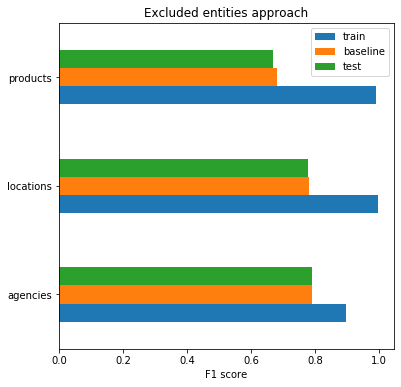

In [19]:
# visualize
p = combined_excluded.set_index('entity_types')[['train', 'baseline',  'test']].plot(
    kind='barh', figsize=(6,6))
p.set_ylabel('');
p.set_xlabel('F1 score')
p.set_title('Excluded entities approach')

Text(0.5, 1.0, 'Year-split entities approach')

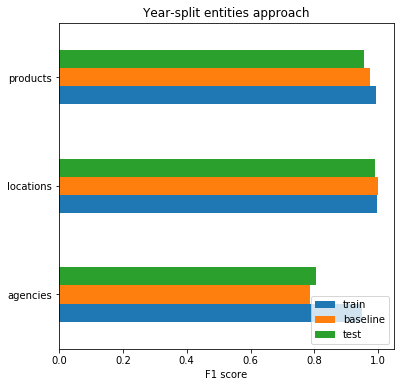

In [83]:
# visualize
p = combined_year.set_index('entity_types')[['train', 'baseline', 'test']].plot(
    kind='barh', figsize=(6,6))
p.set_ylabel('');
p.set_xlabel('F1 score')
p.set_title('Year-split entities approach')

Text(0.5, 1.0, 'Recall by type for each approach')

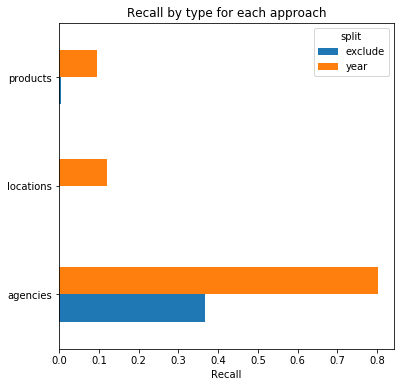

In [93]:
# visualize
recall_plot = combined.set_index(['entity_types', 'split'])['test_recall'].unstack(level=1)
p = recall_plot.plot(
    kind='barh', figsize=(6,6))
p.set_ylabel('');
p.set_xlabel('Recall')
p.set_title('Recall by type for each approach')

In [112]:
# get some example not-identified
from collections import defaultdict
test_data = pickle.load(open('data/year_test_f.pkl'.format(model_v), 'rb'))
not_identified = defaultdict(list)
for i, (doc, annot) in enumerate(test_data):
    missing = set(annot['entities'])- set(year_te_p[i][1]['entities'])
    if len(missing)>0:
        for m in missing:
            not_identified[m[2]].append(doc[m[0]:m[1]])

In [122]:
# get some example not-identified
from collections import defaultdict
test_data = pickle.load(open('data/exclude_test_f.pkl'.format(model_v), 'rb'))
not_identified = defaultdict(list)
for i, (doc, annot) in enumerate(test_data):
    missing = set(annot['entities'])- set(ex_te_p[i][1]['entities'])
    if len(missing)>0:
        for m in missing:
            not_identified[m[2]].append(doc[m[0]:m[1]])

In [ ]:
doc = excluded_model(ex_te_p[0][0])
colors = {"AGENCIES": "#ea9999", 
         "LOCATIONS":"#ffe599",
         "PRODUCTS":"#a4c2f4"}

options = {"ents": ["AGENCIES", "LOCATIONS", "PRODUCTS"], "colors": colors}
displacy.serve(doc, style="ent", options=options)